In [1]:
import json 
import pandas as pd 
import os

# calculate and save median and IQR for all runs 

files = os.listdir('/mnt/home/f0106093/Projects/multiomics-embedding/wandb/')
runs = [f for f in files if 'run' in f]
# runs with embedding average val F1 >= 0.80
ids = ['8lofhbbf', 'dgst6c87', 'wcksnlsg', '7o4yga2v', 'q2gzu1o3']

time_val = []
time_test = []
diet_val = []
diet_test = []
labels = []

# if run is complete load data 
for run in runs:
    root = f'/mnt/home/f0106093/Projects/multiomics-embedding/wandb/{run}/files'
    fp = f'{root}/wandb-summary.json'
    if not os.path.exists(fp):
        continue

    with open(fp, 'r') as f:
        data = json.load(f)

    if len(data) < 241:
        continue
    

    # get validation data 
    time = pd.DataFrame(index=range(10), columns=range(1,6))
    diet = pd.DataFrame(index=range(10), columns=range(1,6))

    for i in range(1,6):
        for j in range(10):
            time.loc[j,i] = data[f'time_model_{i}_val_{j}_f1']
            diet.loc[j,i] = data[f'diet_model_{i}_val_{j}_f1']

    # calculate validation median, IQR and variance
    time_median = time.median()
    time_iqr = time.quantile(0.75) - time.quantile(0.25)
    time_var = time.var()

    diet_median = diet.median()
    diet_iqr = diet.quantile(0.75) - diet.quantile(0.25)
    diet_var = diet.var()

    val_variance = pd.DataFrame({'time_median' : time_median, 'time_IQR' : time_iqr, 'time_variance': time_var, 
                            'diet_median' : diet_median, 'diet_IQR' : diet_iqr, 'diet_variance': diet_var})

    time_val_median = val_variance['time_median'].median()
    time_val_iqr = (val_variance['time_median'].quantile(0.75) - val_variance['time_median'].quantile(0.25))
    time_val_var = val_variance['time_median'].var()

    diet_val_median = val_variance['diet_median'].median()
    diet_val_iqr = (val_variance['diet_median'].quantile(0.75) - val_variance['diet_median'].quantile(0.25))
    diet_val_var = val_variance['diet_median'].var()

    # get test data
    time_t = pd.Series([data[f'time_model_{i}_test_f1'] for i in range(1,6)])
    diet_t = pd.Series([data[f'diet_model_{i}_test_f1'] for i in range(1,6)])

    # calculate test median, IQR and variance
    time_test_median = time_t.median()
    time_test_iqr = time_t.quantile(0.75) - time_t.quantile(0.25)
    time_test_var = time_t.var()

    diet_test_median = diet_t.median()
    diet_test_iqr = diet_t.quantile(0.75) - diet_t.quantile(0.25)
    diet_test_var = diet_t.var()

    variance = pd.DataFrame({
        'time': [time_val_median, time_val_iqr, time_val_var, time_test_median, time_test_iqr, time_test_var],
        'diet': [diet_val_median, diet_val_iqr, diet_val_var, diet_test_median, diet_test_iqr, diet_test_var]
    }, index=['val_median', 'val_IQR', 'val_variance', 'test_median', 'test_IQR', 'test_variance'])

    val_variance.to_csv(f'{root}/validation_variance.tsv', sep='\t')
    variance.to_csv(f'{root}/variance.tsv', sep='\t')

    # for plotting later in script 
    time_val.append((time_val_median, time_val_iqr, time_val_var))
    time_test.append((time_test_median, time_test_iqr, time_test_var))
    diet_val.append((diet_val_median, diet_val_iqr, diet_val_var))
    diet_test.append((diet_test_median, diet_test_iqr, diet_test_var))
    labels.append(run)

# for plotting later in script 
time_val = pd.DataFrame(time_val, columns=['median', 'IQR', 'variance'], index=labels)
time_test = pd.DataFrame(time_test, columns=['median', 'IQR', 'variance'], index=labels)
diet_val = pd.DataFrame(diet_val, columns=['median', 'IQR', 'variance'], index=labels)
diet_test = pd.DataFrame(diet_test, columns=['median', 'IQR', 'variance'], index=labels)

    

In [2]:
import matplotlib.pyplot as plt

def get_color(index, ids):
    for id in ids:
        if id in index:
            return 'orange'
    return 'blue'
colors = [get_color(idx, ids) for idx in time_val.index]

def get_labels(index, ids):
    for id in ids:
        if id in index:
            return id
    return None
point_labels = [get_labels(idx, ids) for idx in time_val.index]

def plot_scatter(ax, x, y, colors, labels, ymax=None):
    # Plot blue points first
    blue_mask = [color == 'blue' for color in colors]
    ax.scatter(x[blue_mask], y[blue_mask], c='blue', alpha=0.5)
    # Plot orange points on top
    orange_mask = [color == 'orange' for color in colors]
    ax.scatter(x[orange_mask], y[orange_mask], c='orange')
    # Add labels
    for i, label in enumerate(labels):
        if label:  # Only add label if it's not an empty string
            ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
    if ymax is not None:
        # Set axis limits
        ax.set_xlim(0.2, 1)
        ax.set_ylim(0, ymax)

/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9,

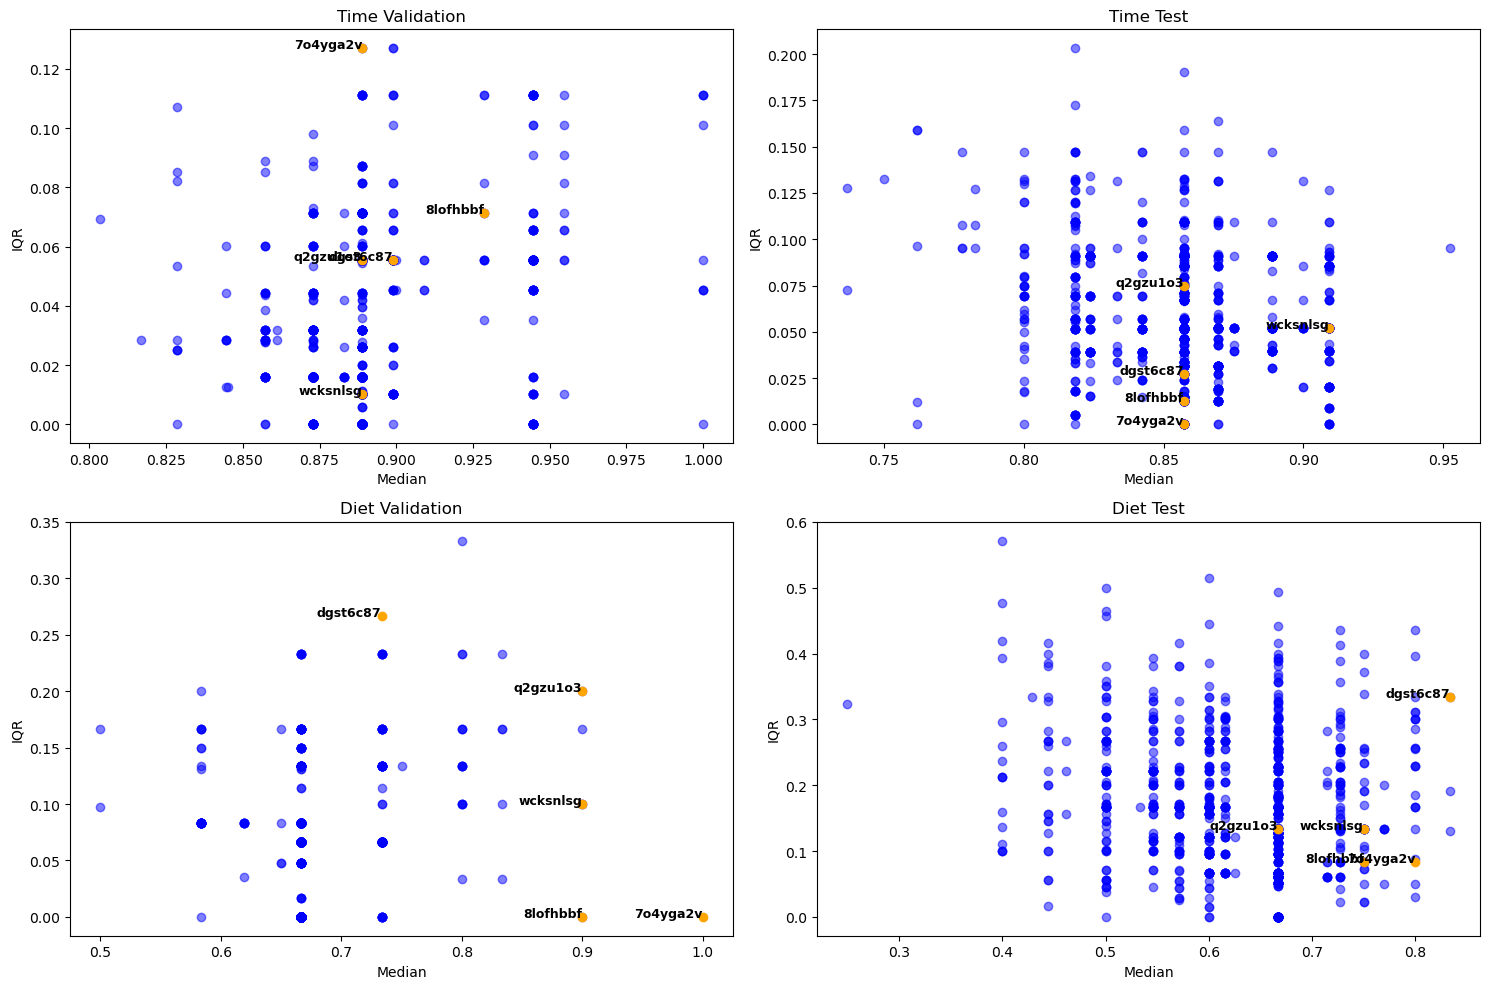

/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9,

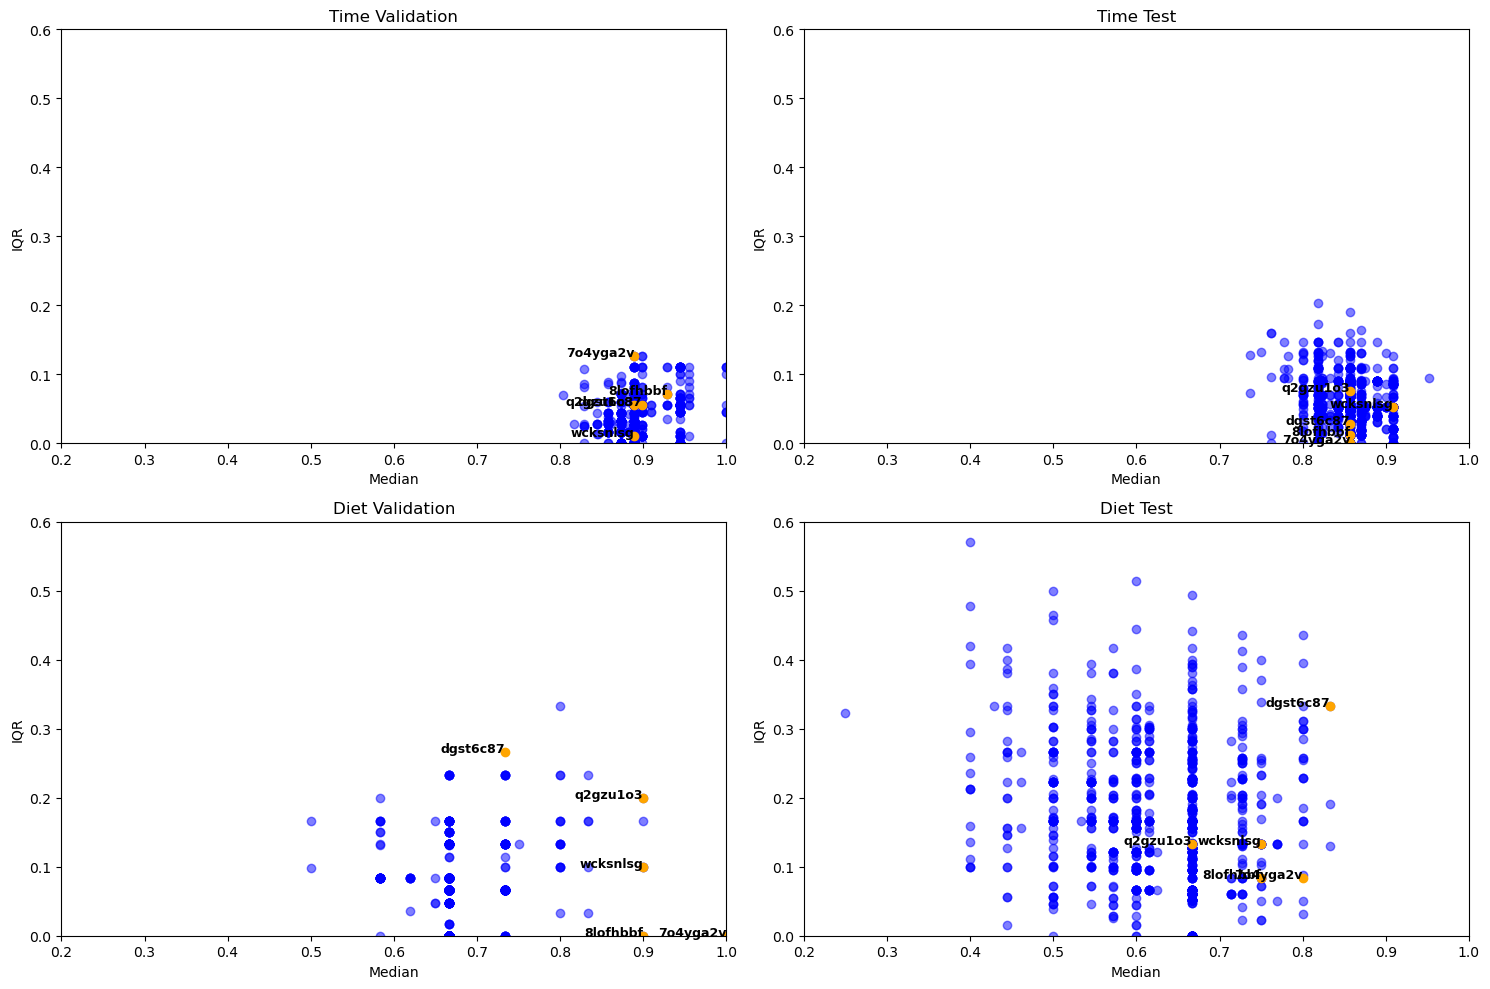

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plot_scatter(axs[0, 0], time_val['median'], time_val['IQR'], colors, point_labels)
axs[0, 0].set_title('Time Validation')
axs[0, 0].set_xlabel('Median')
axs[0, 0].set_ylabel('IQR')

plot_scatter(axs[0, 1], time_test['median'], time_test['IQR'], colors, point_labels)
axs[0, 1].set_title('Time Test')
axs[0, 1].set_xlabel('Median')
axs[0, 1].set_ylabel('IQR')

plot_scatter(axs[1, 0], diet_val['median'], diet_val['IQR'], colors, point_labels)
axs[1, 0].set_title('Diet Validation')
axs[1, 0].set_xlabel('Median')
axs[1, 0].set_ylabel('IQR')

plot_scatter(axs[1, 1], diet_test['median'], diet_test['IQR'], colors, point_labels)
axs[1, 1].set_title('Diet Test')
axs[1, 1].set_xlabel('Median')
axs[1, 1].set_ylabel('IQR')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plot_scatter(axs[0, 0], time_val['median'], time_val['IQR'], colors, point_labels, 0.6)
axs[0, 0].set_title('Time Validation')
axs[0, 0].set_xlabel('Median')
axs[0, 0].set_ylabel('IQR')

plot_scatter(axs[0, 1], time_test['median'], time_test['IQR'], colors, point_labels, 0.6)
axs[0, 1].set_title('Time Test')
axs[0, 1].set_xlabel('Median')
axs[0, 1].set_ylabel('IQR')

plot_scatter(axs[1, 0], diet_val['median'], diet_val['IQR'], colors, point_labels, 0.6)
axs[1, 0].set_title('Diet Validation')
axs[1, 0].set_xlabel('Median')
axs[1, 0].set_ylabel('IQR')

plot_scatter(axs[1, 1], diet_test['median'], diet_test['IQR'], colors, point_labels, 0.6)
axs[1, 1].set_title('Diet Test')
axs[1, 1].set_xlabel('Median')
axs[1, 1].set_ylabel('IQR')

plt.tight_layout()
plt.show()

/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9,

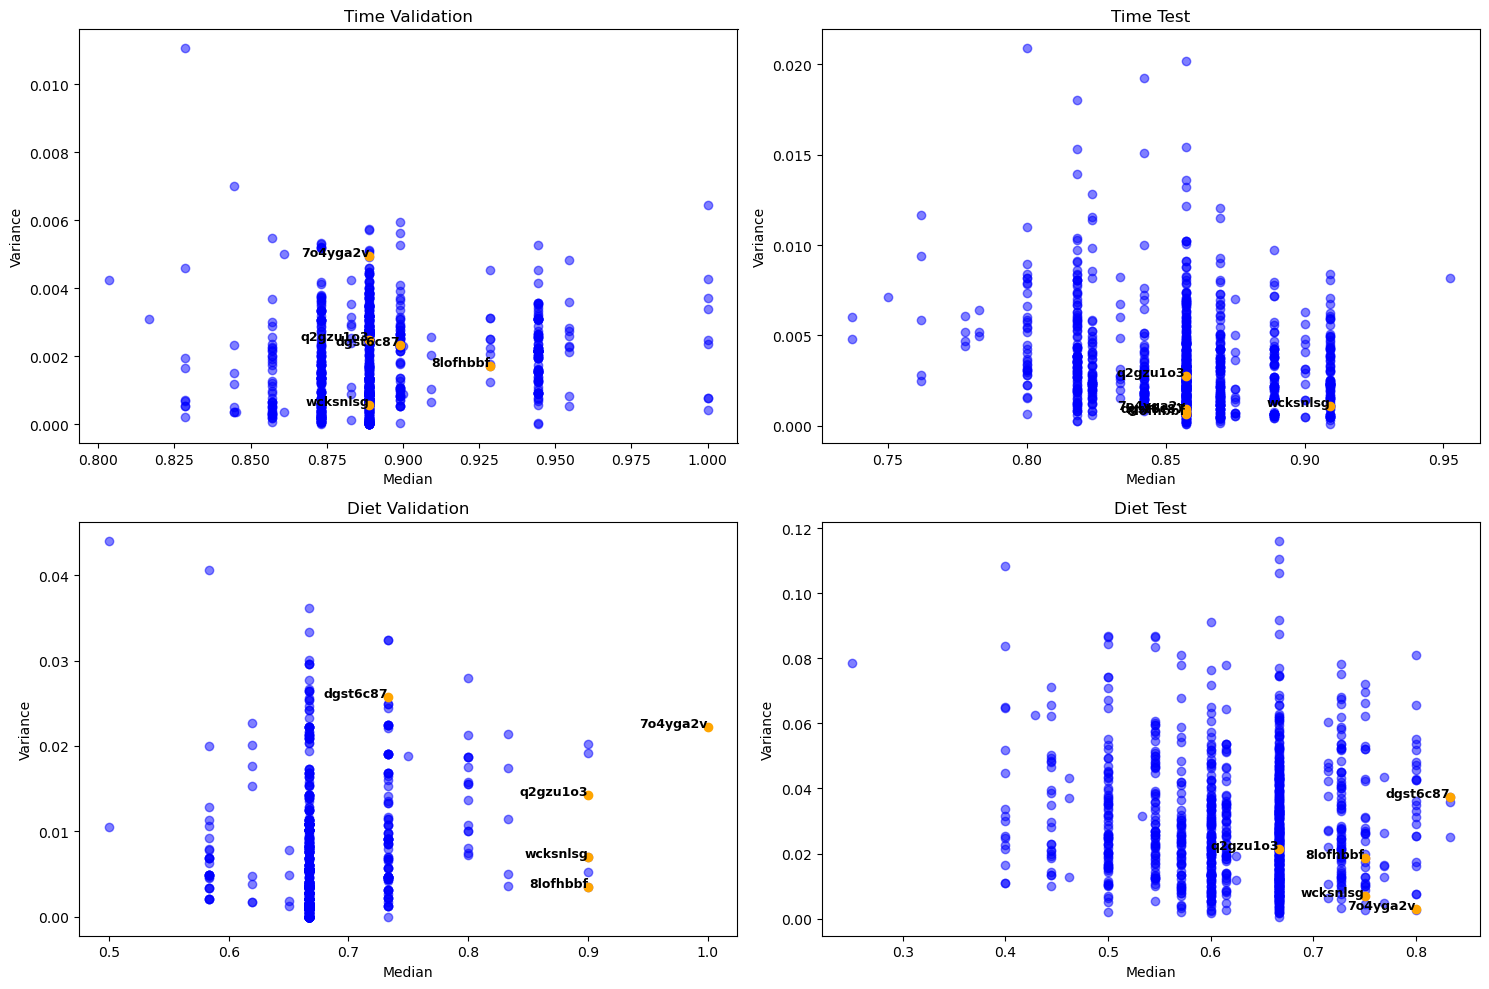

/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_555278/1099243690.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9,

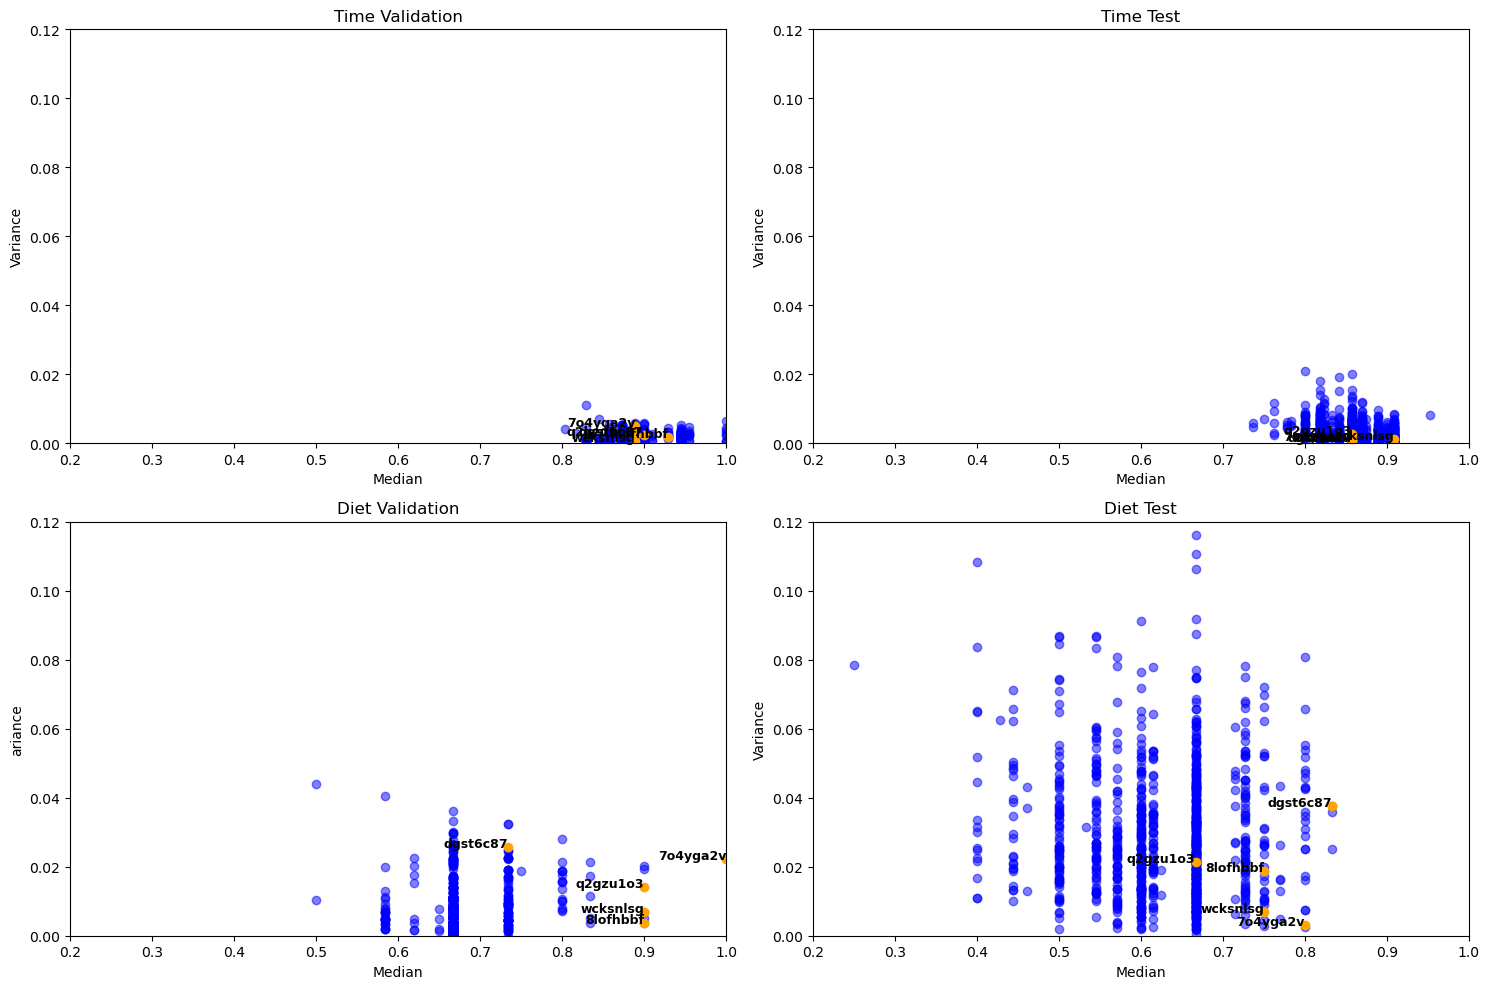

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plot_scatter(axs[0, 0], time_val['median'], time_val['variance'], colors, point_labels)
axs[0, 0].set_title('Time Validation')
axs[0, 0].set_xlabel('Median')
axs[0, 0].set_ylabel('Variance')

plot_scatter(axs[0, 1], time_test['median'], time_test['variance'], colors, point_labels)
axs[0, 1].set_title('Time Test')
axs[0, 1].set_xlabel('Median')
axs[0, 1].set_ylabel('Variance')

plot_scatter(axs[1, 0], diet_val['median'], diet_val['variance'], colors, point_labels)
axs[1, 0].set_title('Diet Validation')
axs[1, 0].set_xlabel('Median')
axs[1, 0].set_ylabel('Variance')

plot_scatter(axs[1, 1], diet_test['median'], diet_test['variance'], colors, point_labels)
axs[1, 1].set_title('Diet Test')
axs[1, 1].set_xlabel('Median')
axs[1, 1].set_ylabel('Variance')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plot_scatter(axs[0, 0], time_val['median'], time_val['variance'], colors, point_labels, 0.12)
axs[0, 0].set_title('Time Validation')
axs[0, 0].set_xlabel('Median')
axs[0, 0].set_ylabel('Variance')

plot_scatter(axs[0, 1], time_test['median'], time_test['variance'], colors, point_labels, 0.12)
axs[0, 1].set_title('Time Test')
axs[0, 1].set_xlabel('Median')
axs[0, 1].set_ylabel('Variance')

plot_scatter(axs[1, 0], diet_val['median'], diet_val['variance'], colors, point_labels, 0.12)
axs[1, 0].set_title('Diet Validation')
axs[1, 0].set_xlabel('Median')
axs[1, 0].set_ylabel('ariance')

plot_scatter(axs[1, 1], diet_test['median'], diet_test['variance'], colors, point_labels, 0.12)
axs[1, 1].set_title('Diet Test')
axs[1, 1].set_xlabel('Median')
axs[1, 1].set_ylabel('Variance')

plt.tight_layout()
plt.show()